In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

In [92]:
torch.manual_seed(0)
np.random.seed(0)

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(20)

        self.conv2 = nn.Conv2d(20, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 64, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.ConvTranspose2d(64, 16, kernel_size=7, stride=1, padding=3)
        self.bn4 = nn.BatchNorm2d(16)

        self.conv5 = nn.ConvTranspose2d(16, 6, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(6)

        self.conv6 = nn.ConvTranspose2d(6, 1, kernel_size=5, stride=1, padding=2) 
        
        self.maxpool = nn.MaxPool2d(kernel_size=2,return_indices=True)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
    
        pred = self.conv1(input)
        pred = self.bn1(self.act(pred))
        layer1 = pred.clone()
        
        pred = self.conv2(pred)
        pred = self.bn2(self.act(pred))
        layer2 = pred.clone()
        
        
        pred, indices = self.maxpool(pred)
        pred = self.unpool(pred, indices)
        maxlayer = pred.clone()
        
        pred = self.conv5(pred)
        pred = self.bn5(self.act(pred))
        layer5 = pred.clone()
        
        pred = self.conv6(pred)
        
        return pred




In [93]:
class AppliancesCNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomCNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [182]:
torch.manual_seed(0)
num_folds = 5
dataset = 3
fold_num = 2
lr = 0.1
train, test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)

In [183]:
valid = train[int(0.8*len(train)):].copy()
train = train[:int(0.8 * len(train))].copy()

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

In [184]:
# ORDER = ['hvac', 'dr', 'fridge', 'dw', 'mw']
ORDER = ['dr']
# ORDER = ['dw', 'mw', 'fridge', 'hvac', 'dr']
cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

In [185]:
ORDER

['dr']

In [186]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_valid = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_valid[a_num] = Variable(
        torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
    if cuda_av:
        out_valid[a_num] = out_valid[a_num].cuda()
        
out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test.shape[0], 1, -1, 24))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

In [187]:
loss_func = nn.L1Loss()
model = AppliancesCNN(len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()

In [188]:
inp = Variable(torch.Tensor(train_aggregate).type(torch.FloatTensor),
               requires_grad=True)

inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()

valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
if cuda_av:
    valid_inp = valid_inp.cuda()

test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

valid_pred = {}
train_pred = {}
test_pred = {}
test_losses = {}
valid_losses = {}

In [189]:
valid_aggregate.shape

(11, 1, 112, 24)

In [190]:
valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

In [191]:
p = 0
num_iterations = 200000
params = [inp, p]
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])
        
for t in range(1, num_iterations+1):
  
    if cuda_av:
        train_out = train_out.cuda()

    
    pred = model(*params)

    optimizer.zero_grad()
    loss = loss_func(pred, train_out)
    if t % 200 == 0:

        if cuda_av:
            valid_inp = valid_inp.cuda()
        valid_params = [valid_inp, -2]
        for i in range(len(ORDER)):
            valid_params.append(None)
        valid_pr = model(*valid_params)
        valid_loss = loss_func(valid_pr, valid_out)

        if cuda_av:
            test_inp = test_inp.cuda()
        test_params = [test_inp, -2]
        for i in range(len(ORDER)):
            test_params.append(None)
        test_pr = model(*test_params)
        test_loss = loss_func(test_pr, test_out)

        test_losses[t] = test_loss.data[0]
        valid_losses[t] = valid_loss.data[0]
        # np.save("./baseline/p_50_loss")

        if t % 200 == 0:
            valid_pr = torch.clamp(valid_pr, min=0.)
            valid_pred[t] = valid_pr
            test_pr = torch.clamp(test_pr, min=0.)
            test_pred[t] = test_pr
            train_pr = pred
            train_pr = torch.clamp(train_pr, min=0.)
            train_pred[t] = train_pr

        print("Round:", t, "Training Error:", loss.data[0], "Validation Error:", valid_loss.data[0], "Test Error:", test_loss.data[0])

    loss.backward()
    optimizer.step()



Round: 200 Training Error: 66.61253356933594 Validation Error: 63.02429962158203 Test Error: 71.01471710205078
Round: 400 Training Error: 66.62625122070312 Validation Error: 63.06496810913086 Test Error: 71.03795623779297
Round: 600 Training Error: 66.62981414794922 Validation Error: 63.07412338256836 Test Error: 71.0433578491211
Round: 800 Training Error: 66.62284088134766 Validation Error: 63.05595016479492 Test Error: 71.03147888183594
Round: 1000 Training Error: 66.6077651977539 Validation Error: 63.006771087646484 Test Error: 71.01158142089844
Round: 1200 Training Error: 66.6402816772461 Validation Error: 63.03800582885742 Test Error: 71.04084014892578
Round: 1400 Training Error: 66.61962890625 Validation Error: 63.044620513916016 Test Error: 71.03158569335938
Round: 1600 Training Error: 66.65812683105469 Validation Error: 63.055912017822266 Test Error: 71.0630874633789
Round: 1800 Training Error: 66.6247787475586 Validation Error: 63.05930709838867 Test Error: 71.04017639160156
R

Round: 15000 Training Error: 66.62130737304688 Validation Error: 63.0498161315918 Test Error: 71.03239440917969
Round: 15200 Training Error: 66.63349914550781 Validation Error: 63.03125 Test Error: 71.03387451171875
Round: 15400 Training Error: 66.61148071289062 Validation Error: 63.01926803588867 Test Error: 71.015869140625
Round: 15600 Training Error: 66.60868072509766 Validation Error: 63.01062774658203 Test Error: 71.0107650756836
Round: 15800 Training Error: 66.63322448730469 Validation Error: 63.030967712402344 Test Error: 71.03292083740234
Round: 16000 Training Error: 66.60874938964844 Validation Error: 63.009769439697266 Test Error: 71.01090240478516
Round: 16200 Training Error: 66.61316680908203 Validation Error: 63.025054931640625 Test Error: 71.01942443847656
Round: 16400 Training Error: 66.61418914794922 Validation Error: 63.02806854248047 Test Error: 71.02119445800781
Round: 16600 Training Error: 66.61556243896484 Validation Error: 63.031578063964844 Test Error: 71.0235977

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1512386481460/work/torch/lib/THC/generic/THCStorage.cu:58

In [192]:
from sklearn.metrics import mean_absolute_error
num_iterations = 24800

In [193]:

train_fold = {}
for t in range(200, num_iterations + 1, 200):
    train_pred[t] = torch.split(train_pred[t], train_aggregate.shape[0])
    train_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].data.numpy().reshape(-1, 24)
            
valid_fold = {}
for t in range(200, num_iterations + 1, 200):

    valid_pred[t] = torch.split(valid_pred[t], valid_aggregate.shape[0])
    valid_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].data.numpy().reshape(-1, 24)

test_fold = {}
for t in range(200, num_iterations + 1, 200):

    test_pred[t] = torch.split(test_pred[t], test_aggregate.shape[0])
    test_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].data.numpy().reshape(-1, 24)

# store ground truth of validation set
valid_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    valid_gt_fold[appliance_num] = valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        valid_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

# calcualte the error of validation set
valid_error = {}
for t in range(200, num_iterations + 1, 200):
    valid_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        valid_error[t][appliance] = mean_absolute_error(valid_fold[t][appliance_num], valid_gt_fold[appliance_num])

test_error = {}
for t in range(200, num_iterations + 1, 200):
    test_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        test_error[t][appliance] = mean_absolute_error(test_fold[t][appliance_num], test_gt_fold[appliance_num])

In [194]:
train_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    train_gt_fold[appliance_num] = train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        train_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

In [195]:
train_error = {}
for t in range(200, num_iterations+1, 200):
    train_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        train_error[t][appliance] = mean_absolute_error(train_fold[t][appliance_num], train_gt_fold[appliance_num])

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [197]:
test_aggregate.shape

(14, 1, 112, 24)

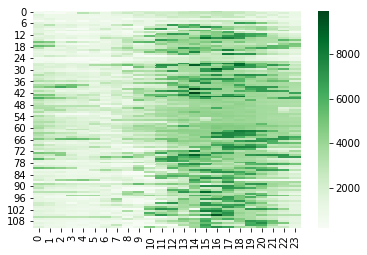

In [198]:
sns.heatmap(pd.DataFrame(test_aggregate[0][0]), cmap='Greens')

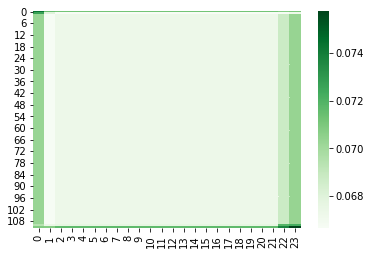

In [202]:
sns.heatmap(pd.DataFrame(test_fold[2800][0].reshape(-1, 112, 24)[5]), cmap='Greens')

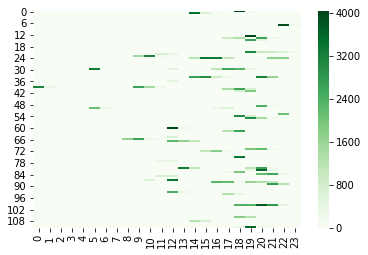

In [200]:
sns.heatmap(pd.DataFrame(test_gt_fold[0].reshape(-1, 112, 24)[5]), cmap='Greens')

In [180]:
def onoff_error(pred, gt, threshold):
    abs_error = np.abs(pred-gt)
    error = [x for x in abs_error.reshape(1, -1).tolist()[0] if x >= threshold]
    
    return np.mean(error)

In [203]:
for t in range(200, num_iterations+1, 200):

    print(t, onoff_error(test_fold[t][0], test_gt_fold[0], 10))

200 1063.17543576
400 1063.94259795
600 1063.93326878
800 1063.97075715
1000 1061.96431481
1200 1061.95977987
1400 1062.73604499
1600 1061.54603325
1800 1063.13253497
2000 1061.94429575
2200 1061.95896398
2400 1063.97005991
2600 1063.19382195
2800 1063.56351157
3000 1063.55132026
3200 1063.18204011
3400 1063.95279368
3600 1063.16854866
3800 1063.1544597
4000 1063.90606362
4200 1063.95660095
4400 1063.16735982
4600 1063.1686905
4800 1063.55414578
5000 1063.16244559
5200 1063.15795332
5400 1063.19152787
5600 1063.96662131
5800 1063.17109256
6000 1062.78614689
6200 1063.16834259
6400 1063.93223355
6600 1063.20477026
6800 1063.16389795
7000 1063.15418247
7200 1063.20508319
7400 1062.78616456
7600 1063.17995565
7800 1063.1536081
8000 1063.8824483
8200 1063.89780374
8400 1063.93207345
8600 1063.94593893
8800 1063.20773224
9000 1063.19459706
9200 1063.20339337
9400 1062.78615443
9600 1063.92248762
9800 1063.18892197
10000 1063.19380257
10200 1063.1787738
10400 1063.55821753
10600 1062.7861671

In [49]:
train_gt_fold[2]

array([[ 0.2       ,  0.26666668,  0.2       , ...,  1.41666663,
         1.26666665,  2.6833334 ],
       [ 1.64999998,  1.36666667,  0.64999998, ...,  0.33333334,
         1.64999998,  1.68333328],
       [ 0.63333333,  0.55000001,  0.98333335, ...,  1.63333333,
         0.64999998,  0.66666669],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.2       ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [47]:
train_fold[200][2]

array([[ 0.        ,  0.        ,  0.        , ...,  0.00033851,
         0.        ,  0.        ],
       [ 0.00239093,  0.00081312,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.0097909 ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00337324,  0.        ,  0.00121355, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.0051079 ]], dtype=float32)

In [37]:
pd.DataFrame(test_error)

,200,400,600,800,1000,1200,1400,1600,1800,2000
dr,71.004390,71.168054,72.256811,74.267883,76.755139,77.602587,78.730931,79.122479,79.205312,79.504459
dw,19.549013,19.556208,19.538995,19.558140,19.540490,19.538111,19.538131,19.537917,19.552066,19.537951
fridge,30.020225,31.739404,33.176804,34.401962,35.232226,35.295100,35.884477,36.351166,36.610283,36.548123
hvac,345.626050,332.520962,326.693016,329.828265,336.977560,335.423433,338.235341,343.442527,343.997589,344.967933
mw,6.838494,7.412712,7.580235,7.464459,7.741110,8.077630,8.831316,9.520062,9.599482,9.821674


In [14]:
test_error

{1000: {'dr': 104.51486100150184,
  'dw': 11.024693286003417,
  'fridge': 43.628079512353146,
  'hvac': 170.66594519918587,
  'mw': 7.1834119964077372},
 2000: {'dr': 132.7653845653841,
  'dw': 11.024307860026147,
  'fridge': 47.901991705041326,
  'hvac': 181.09079424734418,
  'mw': 7.1065447021710924},
 3000: {'dr': 139.08151216003162,
  'dw': 11.024774495282799,
  'fridge': 47.871046935981276,
  'hvac': 183.52738505555899,
  'mw': 7.2129953022498627},
 4000: {'dr': 143.52523411012223,
  'dw': 11.024311092145034,
  'fridge': 47.957222381518989,
  'hvac': 183.53725180561787,
  'mw': 7.3162178633638364},
 5000: {'dr': 147.3578787644916,
  'dw': 11.024311247478749,
  'fridge': 46.48262682793203,
  'hvac': 182.57096604425192,
  'mw': 7.3999224717760086},
 6000: {'dr': 149.68912326295776,
  'dw': 11.024307778145825,
  'fridge': 47.255146366351035,
  'hvac': 181.87193982892714,
  'mw': 7.3724442526361926},
 7000: {'dr': 151.1437072533798,
  'dw': 11.024307853860456,
  'fridge': 46.717229327